In [1]:
# Core libraries
import numpy as np
import pandas as pd
from collections import defaultdict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: model selection, modeling, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

# Scikit-learn: metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    precision_recall_curve
)

# Oversampling Method (Like SMOTE)
from imblearn.over_sampling import RandomOverSampler

# AIF360: fairness-aware tools
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# Outlier detection
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv", delimiter=',') # Loading the dataset

   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       0.0        1.0  26.0     0.0     0.0   
1              0.0     1.0       1.0        1.0  26.0     1.0     1.0   
2              0.0     0.0       0.0        1.0  26.0     0.0     0.0   
3              0.0     1.0       1.0        1.0  28.0     1.0     0.0   
4              0.0     0.0       0.0        1.0  29.0     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                   0.0           1.0     0.0      1.0                0.0   
1                   0.0           0.0     1.0      0.0                0.0   
2                   0.0           1.0     1.0      1.0                0.0   
3                   0.0           1.0     1.0      1.0                0.0   
4                   0.0           1.0     1.0      1.0                0.0   

   AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  \
0            1.0     

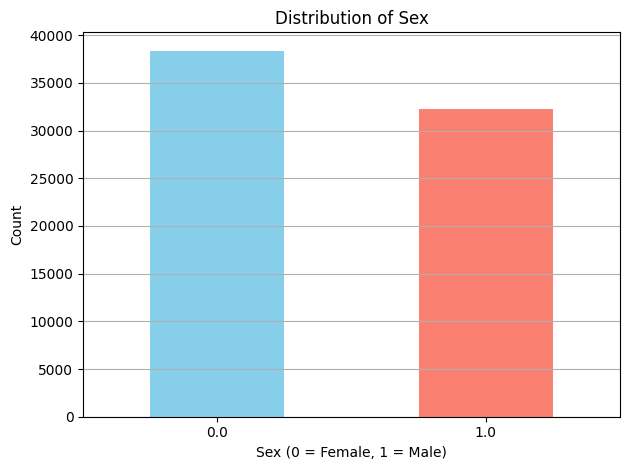

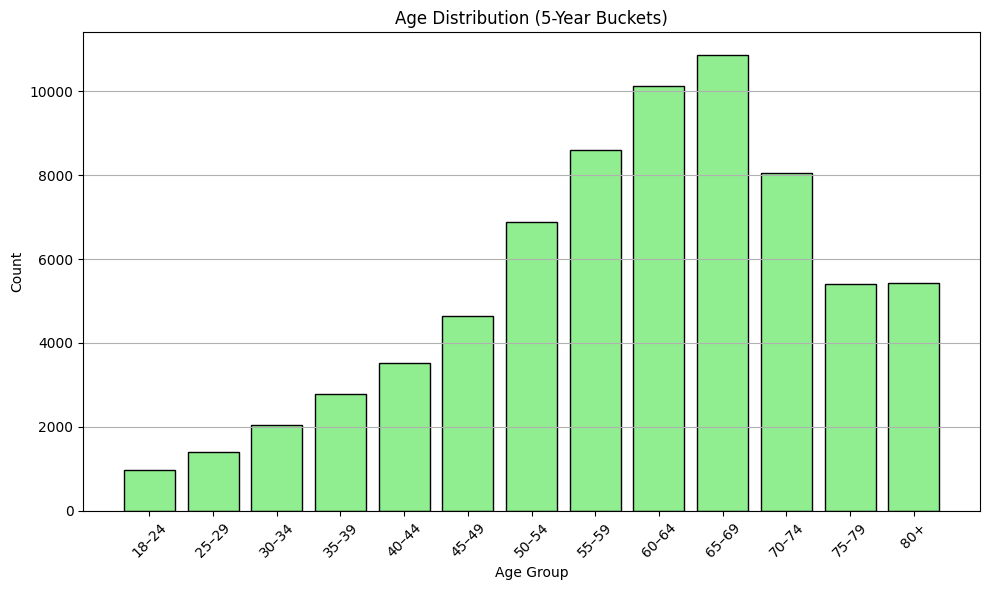

In [100]:
print(df.head())
print(df.shape)
print(df.columns)

df['Sex'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)' if df['Sex'].isin([0, 1]).all() else 'Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Define bucket labels for age codes 1–13
age_labels = [
    '18–24', '25–29', '30–34', '35–39', '40–44', '45–49',
    '50–54', '55–59', '60–64', '65–69', '70–74', '75–79', '80+'
]

# Create a bar plot using value_counts, sorted by age group order
age_counts = df['Age'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values, color='lightgreen', edgecolor='black')

# Set x-axis with proper age bucket labels
plt.xticks(ticks=range(1, 14), labels=age_labels, rotation=45)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution (5-Year Buckets)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [52]:
columns = ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income']
protected_classes = ['Sex', 'Age_binary', 'Age']
additional_protected_class_replaced = ['Age']
label_columns = ['Diabetes_binary', 'HeartDiseaseorAttack']
df['Age_binary'] = (df['Age'] < 8).astype(int)

# ETL/EDA

       Diabetes_binary        HighBP      HighChol     CholCheck  \
count     70692.000000  70692.000000  70692.000000  70692.000000   
mean          0.500000      0.563458      0.525703      0.975259   
std           0.500004      0.495960      0.499342      0.155336   
min           0.000000      0.000000      0.000000      0.000000   
25%           0.000000      0.000000      0.000000      1.000000   
50%           0.500000      1.000000      1.000000      1.000000   
75%           1.000000      1.000000      1.000000      1.000000   
max           1.000000      1.000000      1.000000      1.000000   

                BMI        Smoker        Stroke  HeartDiseaseorAttack  \
count  70692.000000  70692.000000  70692.000000          70692.000000   
mean      29.856985      0.475273      0.062171              0.147810   
std        7.113954      0.499392      0.241468              0.354914   
min       12.000000      0.000000      0.000000              0.000000   
25%       25.000000   

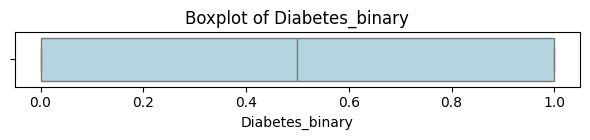

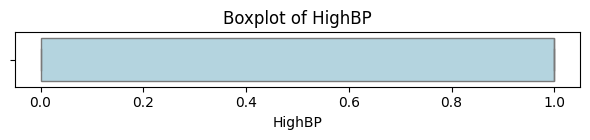

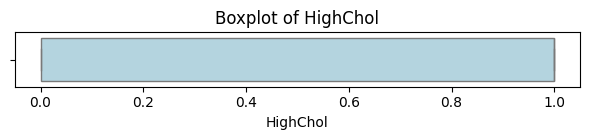

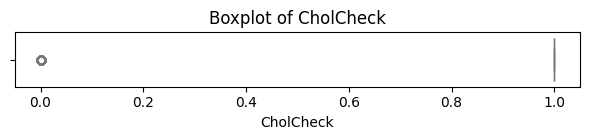

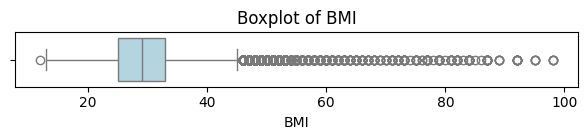

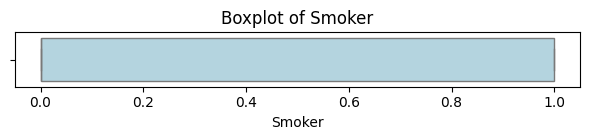

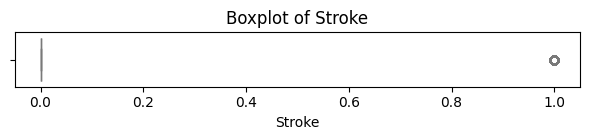

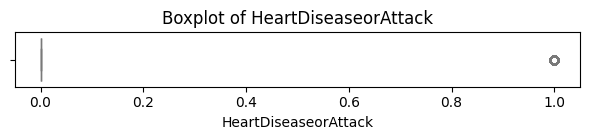

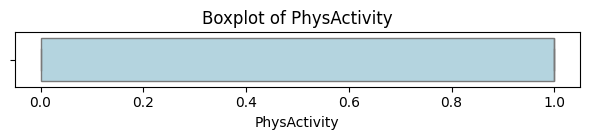

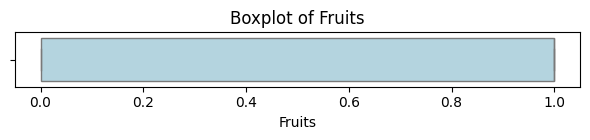

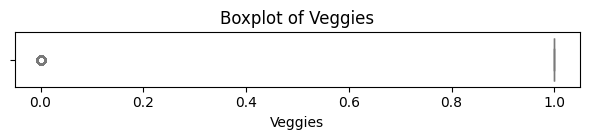

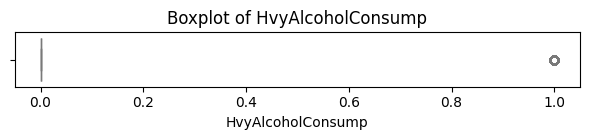

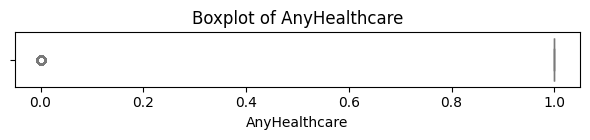

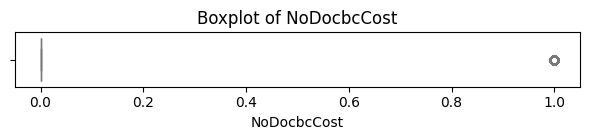

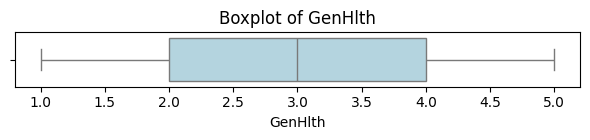

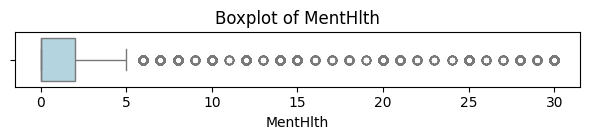

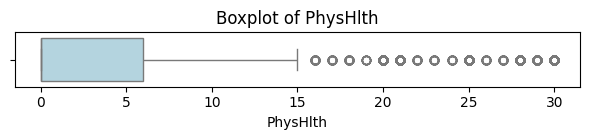

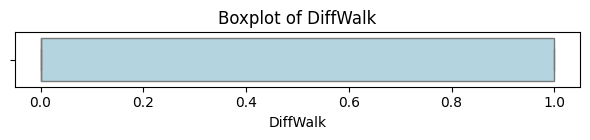

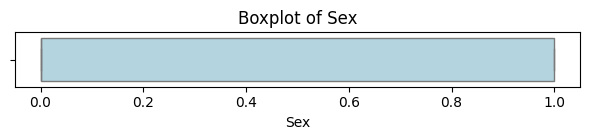

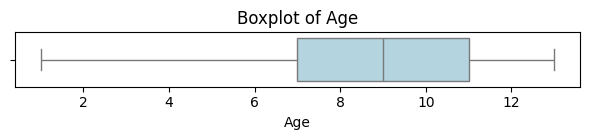

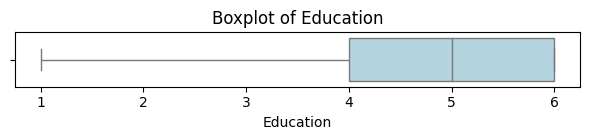

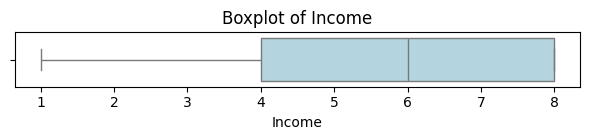

Text(0.5, 1.0, 'Diabetes data rate by Age Bucket')

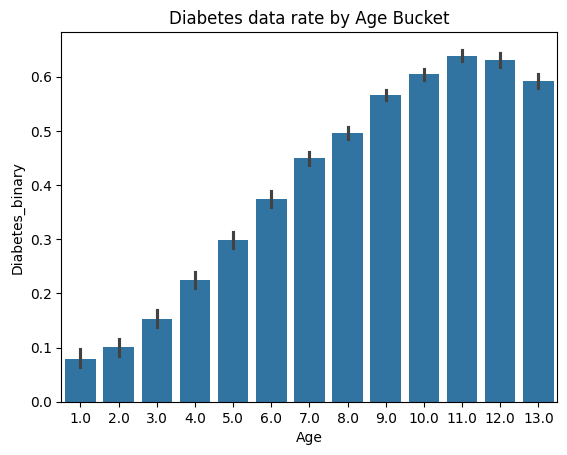

In [53]:
print(df.describe())
for col in columns:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

sns.barplot(x='Age', y='Diabetes_binary', data=df)
plt.title("Diabetes data rate by Age Bucket")

Diabetes_binary          2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
Age_binary               2
dtype: int64


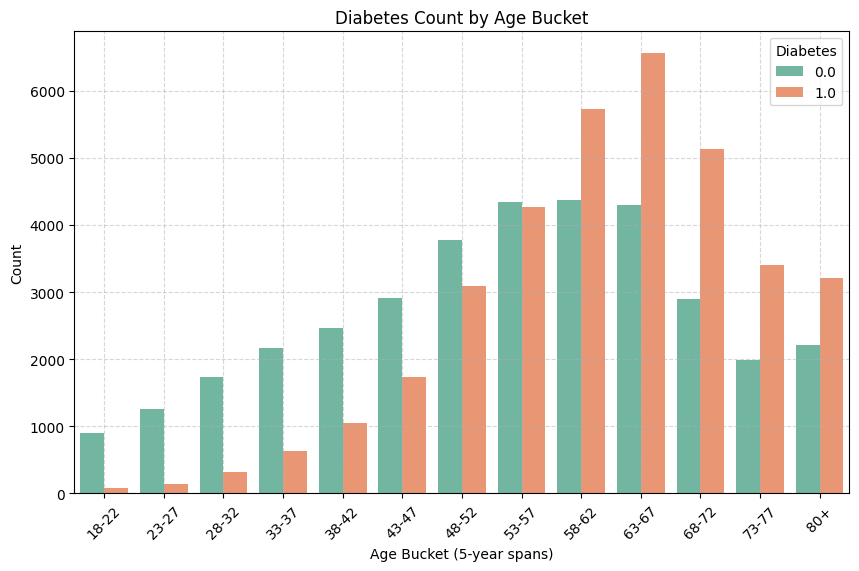

In [106]:
print(df.nunique())

# 1. Calculate the mean outcome (prevalence) per Age bucket
age_outcome = df.groupby('Age')['Diabetes_binary'].mean().reset_index()

# 2. Visualize the diabetes rate across age buckets
age_labels = [f'{18 + 5*i}-{22 + 5*i}' for i in range(12)] + ['80+']

plt.figure(figsize=(10, 6))
sns.countplot(x='Age', hue='Diabetes_binary', data=df, palette='Set2')
plt.title('Diabetes Count by Age Bucket')
plt.xlabel('Age Bucket (5-year spans)')
plt.ylabel('Count')
plt.xticks(ticks=range(13), labels=age_labels, rotation=45)
plt.legend(title='Diabetes')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

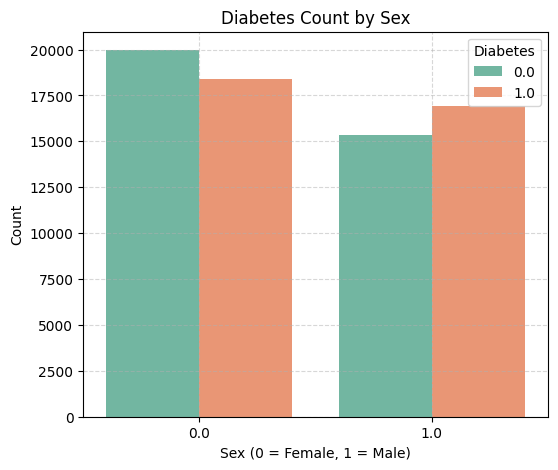

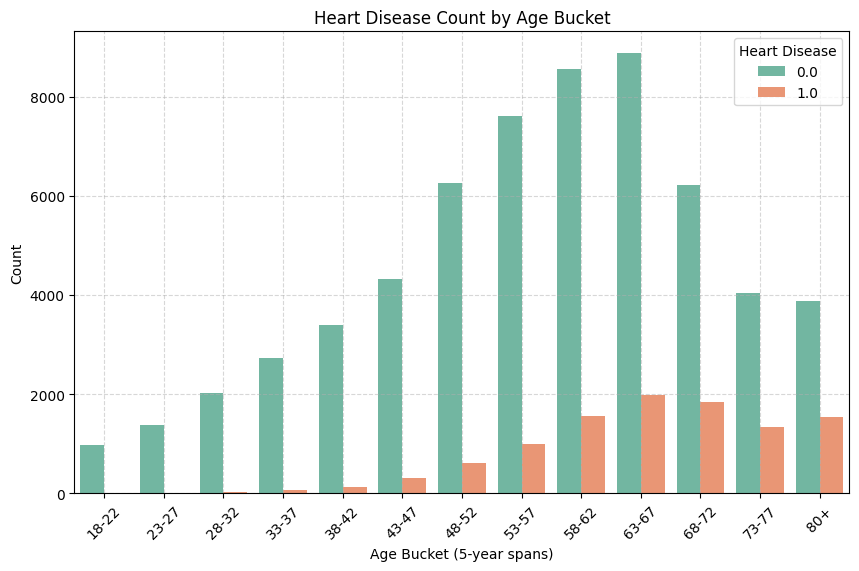

In [105]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Sex', hue='Diabetes_binary', data=df, palette='Set2')
plt.title('Diabetes Count by Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Count')
plt.legend(title='Diabetes')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Optional: Label mapping
age_labels = [f'{18 + 5*i}-{22 + 5*i}' for i in range(12)] + ['80+']

plt.figure(figsize=(10, 6))
sns.countplot(x='Age', hue='HeartDiseaseorAttack', data=df, palette='Set2')
plt.title('Heart Disease Count by Age Bucket')
plt.xlabel('Age Bucket (5-year spans)')
plt.ylabel('Count')
plt.xticks(ticks=range(13), labels=age_labels, rotation=45)
plt.legend(title='Heart Disease')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


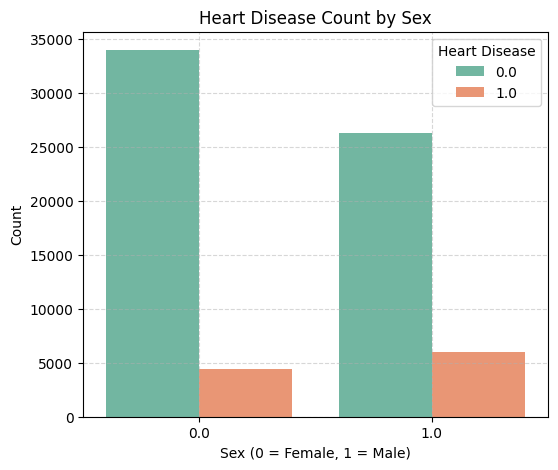

In [104]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Sex', hue='HeartDiseaseorAttack', data=df, palette='Set2')
plt.title('Heart Disease Count by Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Count')
plt.legend(title='Heart Disease')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

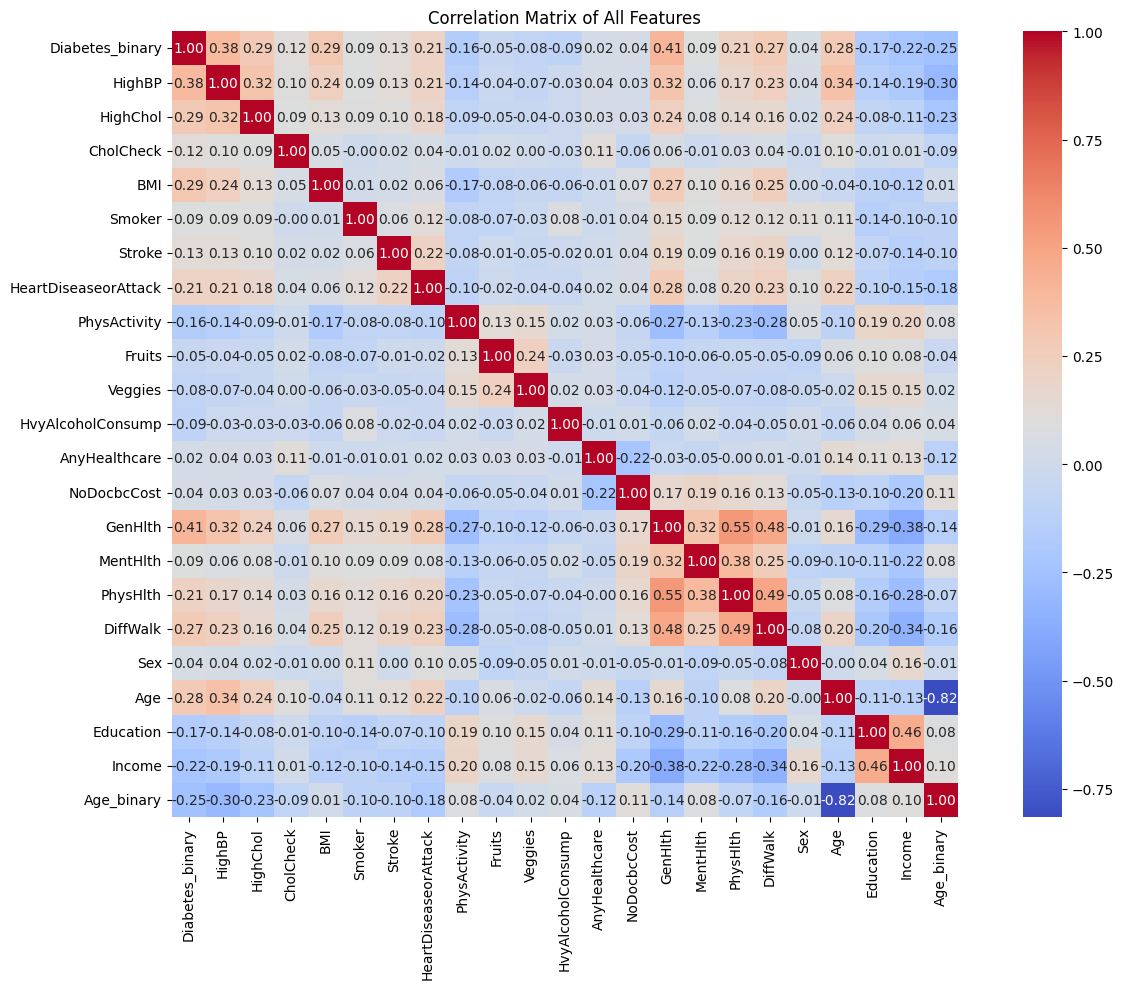

In [55]:
plt.figure(figsize=(14, 10))
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix of All Features")
plt.tight_layout()
plt.show()

In [108]:
table_sex_diabetes = pd.crosstab(df['Sex'], df['Diabetes_binary'], margins=True)
print("Frequency Table: Sex and Diabetes_binary")
print(table_sex_diabetes)

table_sex_heart = pd.crosstab(df['Sex'], df['HeartDiseaseorAttack'], margins=True)
print("\nFrequency Table: Sex and HeartDiseaseorAttack")
print(table_sex_heart)

table_age_diabetes = pd.crosstab(df['Age'], df['Diabetes_binary'], margins=True)
print("\nFrequency Table: Age and Diabetes_binary")
print(table_age_diabetes)

table_age_heart = pd.crosstab(df['Age'], df['HeartDiseaseorAttack'], margins=True)
print("\nFrequency Table: Age and HeartDiseaseorAttack")
print(table_age_heart)

Frequency Table: Sex and Diabetes_binary
Diabetes_binary    0.0    1.0    All
Sex                                 
0.0              19975  18411  38386
1.0              15371  16935  32306
All              35346  35346  70692

Frequency Table: Sex and HeartDiseaseorAttack
HeartDiseaseorAttack    0.0    1.0    All
Sex                                      
0.0                   33939   4447  38386
1.0                   26304   6002  32306
All                   60243  10449  70692

Frequency Table: Age and Diabetes_binary
Diabetes_binary    0.0    1.0    All
Age                                 
1.0                901     78    979
2.0               1256    140   1396
3.0               1735    314   2049
4.0               2167    626   2793
5.0               2469   1051   3520
6.0               2906   1742   4648
7.0               3784   3088   6872
8.0               4340   4263   8603
9.0               4379   5733  10112
10.0              4298   6558  10856
11.0              2903   5141  

In [56]:
target1 = 'Diabetes_binary'
target2 = 'HeartDiseaseorAttack'

print(f"\nCorrelation of all features with target: {target1}")
print(corr_matrix[target1].sort_values(ascending=False))

print(f"\nCorrelation of all features with target: {target2}")
print(corr_matrix[target2].sort_values(ascending=False))


Correlation of all features with target: Diabetes_binary
Diabetes_binary         1.000000
GenHlth                 0.407612
HighBP                  0.381516
BMI                     0.293373
HighChol                0.289213
Age                     0.278738
DiffWalk                0.272646
PhysHlth                0.213081
HeartDiseaseorAttack    0.211523
Stroke                  0.125427
CholCheck               0.115382
MentHlth                0.087029
Smoker                  0.085999
Sex                     0.044413
NoDocbcCost             0.040977
AnyHealthcare           0.023191
Fruits                 -0.054077
Veggies                -0.079293
HvyAlcoholConsump      -0.094853
PhysActivity           -0.158666
Education              -0.170481
Income                 -0.224449
Age_binary             -0.249108
Name: Diabetes_binary, dtype: float64

Correlation of all features with target: HeartDiseaseorAttack
HeartDiseaseorAttack    1.000000
GenHlth                 0.275868
DiffWalk        

In [57]:
# Drop target(s) to isolate independent features, check for multicollinearity
X = df.drop(columns=['Diabetes_binary', 'HeartDiseaseorAttack'])  # choosing the two independent variables
X_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("\nVariance Inflation Factor (VIF) for each feature (1: no multicollinearity, 5+: concerning, 10+: multicollinear):")
print(vif_data.sort_values(by="VIF", ascending=False))


Variance Inflation Factor (VIF) for each feature (1: no multicollinearity, 5+: concerning, 10+: multicollinear):
              feature         VIF
0               const  159.470258
18                Age    3.264171
21         Age_binary    3.005790
13            GenHlth    1.868634
15           PhysHlth    1.699386
16           DiffWalk    1.583349
20             Income    1.543812
1              HighBP    1.354872
19          Education    1.331910
14           MentHlth    1.267162
4                 BMI    1.180601
2            HighChol    1.175775
7        PhysActivity    1.167769
12        NoDocbcCost    1.143382
9             Veggies    1.103250
8              Fruits    1.101479
11      AnyHealthcare    1.095621
5              Smoker    1.080074
17                Sex    1.076074
6              Stroke    1.069636
3           CholCheck    1.032879
10  HvyAlcoholConsump    1.022553


# Testing and Training: LogReg and RandomForest

In [58]:
df_new = df.copy()

train_df, test_df = train_test_split(
    df_new,
    test_size=0.2,
    stratify=df_new[label_columns],
    random_state=42
)

X_train = train_df.drop(columns=protected_classes + label_columns)
y_train = train_df[label_columns]

X_test = test_df.drop(columns=protected_classes + label_columns)
y_test = test_df[label_columns]

In [59]:
# Define target variables for threshold comparison testing
y_true_diabetes = y_test['Diabetes_binary']
y_true_heart = y_test['HeartDiseaseorAttack']

# Wrap a base classifier with the multioutputclassifer
base_model1 = RandomForestClassifier()
model1 = MultiOutputClassifier(base_model1)

model1.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [60]:
base_model2 = LogisticRegression(max_iter=1000)
model2 = MultiOutputClassifier(base_model2)

model2.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [61]:
def model_testing(X_test,model,diabetes_proba_threshold,heart_proba_threshold,model_name):
    y_proba1 = model1.predict_proba(X_test)
    # Extract probabilities for the positive class (index 1)
    diabetes_proba1 = y_proba1[0][:, 1]
    heart_proba1 = y_proba1[1][:, 1]
    
    # Apply custom thresholds
    diabetes_pred1 = (diabetes_proba1 >= diabetes_proba_threshold).astype(int)
    heart_pred1 = (heart_proba1 >= heart_proba_threshold).astype(int)
    
    # Combine predictions
    custom_preds1 = np.column_stack((diabetes_pred1, heart_pred1))
    
    print(f"\nDiabetes_binary Report - {model_name}")
    print(classification_report(y_test.iloc[:, 0], diabetes_pred1))
    
    print(f"\nHeartDiseaseorAttack Report - {model_name}")
    print(classification_report(y_test.iloc[:, 1], heart_pred1))

    # Compute precision-recall and best threshold for diabetes
    precision_d, recall_d, thresholds_d = precision_recall_curve(y_true_diabetes, diabetes_proba1)
    f1_scores_d = 2 * (precision_d * recall_d) / (precision_d + recall_d + 1e-8)  # Add epsilon to avoid /0
    best_idx_d = np.argmax(f1_scores_d)
    best_threshold_d = thresholds_d[best_idx_d]
    
    # Compute precision-recall and best threshold for heart disease
    precision_h, recall_h, thresholds_h = precision_recall_curve(y_true_heart, heart_proba1)
    f1_scores_h = 2 * (precision_h * recall_h) / (precision_h + recall_h + 1e-8)
    best_idx_h = np.argmax(f1_scores_h)
    best_threshold_h = thresholds_h[best_idx_h]
    
    # Print best thresholds
    print(f"Best threshold for diabetes ({model_name}): {best_threshold_d:.2f}")
    print(f"Best threshold for heart disease ({model_name}): {best_threshold_h:.2f}")

In [62]:
y_proba1 = model1.predict_proba(X_test)
y_proba2 = model2.predict_proba(X_test)

In [63]:
# Extract probabilities for the positive class (index 1)
diabetes_proba1 = y_proba1[0][:, 1]
heart_proba1 = y_proba1[1][:, 1]

# Apply custom thresholds
diabetes_pred1 = (diabetes_proba1 >= 0.35).astype(int)
heart_pred1 = (heart_proba1 >= 0.23).astype(int)

# Combine predictions
custom_preds1 = np.column_stack((diabetes_pred1, heart_pred1))

In [64]:
print("Diabetes_binary Report - Random Forest")
print(classification_report(y_test.iloc[:, 0], diabetes_pred1))

print("HeartDiseaseorAttack Report - Random Forest")
print(classification_report(y_test.iloc[:, 1], heart_pred1))

Diabetes_binary Report - Random Forest
              precision    recall  f1-score   support

         0.0       0.80      0.53      0.64      7069
         1.0       0.65      0.86      0.74      7070

    accuracy                           0.70     14139
   macro avg       0.72      0.70      0.69     14139
weighted avg       0.72      0.70      0.69     14139

HeartDiseaseorAttack Report - Random Forest
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84     12049
         1.0       0.30      0.55      0.39      2090

    accuracy                           0.75     14139
   macro avg       0.61      0.67      0.62     14139
weighted avg       0.82      0.75      0.77     14139



In [65]:
# Extract probabilities for the positive class (index 1)
diabetes_proba2 = y_proba2[0][:, 1]
heart_proba2 = y_proba2[1][:, 1]

# Apply custom thresholds
diabetes_pred2 = (diabetes_proba2 >= 0.34).astype(int)
heart_pred2 = (heart_proba2 >= 0.2).astype(int)

# Combine predictions
custom_preds2 = np.column_stack((diabetes_pred2, heart_pred2))

In [66]:
print("Diabetes_binary Report - Logistic Regression")
print(classification_report(y_test.iloc[:, 0], diabetes_pred2))

print("HeartDiseaseorAttack Report - Logistic Regression")
print(classification_report(y_test.iloc[:, 1], heart_pred2))

Diabetes_binary Report - Logistic Regression
              precision    recall  f1-score   support

         0.0       0.83      0.56      0.67      7069
         1.0       0.67      0.88      0.76      7070

    accuracy                           0.72     14139
   macro avg       0.75      0.72      0.72     14139
weighted avg       0.75      0.72      0.72     14139

HeartDiseaseorAttack Report - Logistic Regression
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86     12049
         1.0       0.34      0.59      0.43      2090

    accuracy                           0.77     14139
   macro avg       0.63      0.70      0.64     14139
weighted avg       0.83      0.77      0.79     14139



In [67]:
# Compute precision-recall and best threshold for diabetes
precision_d, recall_d, thresholds_d = precision_recall_curve(y_true_diabetes, diabetes_proba1)
f1_scores_d = 2 * (precision_d * recall_d) / (precision_d + recall_d + 1e-8)  # Add epsilon to avoid /0
best_idx_d = np.argmax(f1_scores_d)
best_threshold_d = thresholds_d[best_idx_d]

# Compute precision-recall and best threshold for heart disease
precision_h, recall_h, thresholds_h = precision_recall_curve(y_true_heart, heart_proba1)
f1_scores_h = 2 * (precision_h * recall_h) / (precision_h + recall_h + 1e-8)
best_idx_h = np.argmax(f1_scores_h)
best_threshold_h = thresholds_h[best_idx_h]

# Print best thresholds
print(f"Best threshold for diabetes (random forest): {best_threshold_d:.2f}")
print(f"Best threshold for heart disease (random forest): {best_threshold_h:.2f}")

Best threshold for diabetes (random forest): 0.32
Best threshold for heart disease (random forest): 0.22


In [68]:
# Compute precision-recall and best threshold for diabetes
precision_d, recall_d, thresholds_d = precision_recall_curve(y_true_diabetes, diabetes_proba2)
f1_scores_d = 2 * (precision_d * recall_d) / (precision_d + recall_d + 1e-8)  # Add epsilon to avoid /0
best_idx_d = np.argmax(f1_scores_d)
best_threshold_d = thresholds_d[best_idx_d]

# Compute precision-recall and best threshold for heart disease
precision_h, recall_h, thresholds_h = precision_recall_curve(y_true_heart, heart_proba2)
f1_scores_h = 2 * (precision_h * recall_h) / (precision_h + recall_h + 1e-8)
best_idx_h = np.argmax(f1_scores_h)
best_threshold_h = thresholds_h[best_idx_h]

# Print best thresholds
print(f"Best threshold for diabetes (logstic regression): {best_threshold_d:.2f}")
print(f"Best threshold for heart disease (logstic regression): {best_threshold_h:.2f}")

Best threshold for diabetes (logstic regression): 0.34
Best threshold for heart disease (logstic regression): 0.20


In [76]:
# Diabetes metrics
diabetes_true = y_test.iloc[:, 0]
diabetes_pred = diabetes_pred1  # From thresholded prediction earlier

diabetes_accuracy = accuracy_score(diabetes_true, diabetes_pred)
diabetes_f1_macro = f1_score(diabetes_true, diabetes_pred, average='macro')
diabetes_conf_matrix = confusion_matrix(diabetes_true, diabetes_pred)
diabetes_tn, diabetes_fp, diabetes_fn, diabetes_tp = diabetes_conf_matrix.ravel()
diabetes_classification_report = classification_report(diabetes_true, diabetes_pred)

# Heart disease metrics
heart_true = y_test.iloc[:, 1]
heart_pred = heart_pred1

heart_accuracy = accuracy_score(heart_true, heart_pred)
heart_f1_macro = f1_score(heart_true, heart_pred, average='macro')
heart_conf_matrix = confusion_matrix(heart_true, heart_pred)
heart_tn, heart_fp, heart_fn, heart_tp = heart_conf_matrix.ravel()
heart_classification_report = classification_report(heart_true, heart_pred)

print("Diabetes_binary Model Evaluation - Random Forest")
print("----------------------------------")
print(f"Accuracy: {diabetes_accuracy:.4f}")
print(f"F1 Score (macro): {diabetes_f1_macro:.4f}")
print("\nConfusion Matrix:")
print(f"[[TN: {diabetes_tn}  FP: {diabetes_fp}]\n [FN: {diabetes_fn}  TP: {diabetes_tp}]]")

print("\nClassification Report:")
print(diabetes_classification_report)

print("\nHeartDiseaseorAttack Model Evaluation - Random Forest")
print("----------------------------------------")
print(f"Accuracy: {heart_accuracy:.4f}")
print(f"F1 Score (macro): {heart_f1_macro:.4f}")
print("\nConfusion Matrix:")
print(f"[[TN: {heart_tn}  FP: {heart_fp}]\n [FN: {heart_fn}  TP: {heart_tp}]]")

print("\nClassification Report:")
print(heart_classification_report)

Diabetes_binary Model Evaluation - Random Forest
----------------------------------
Accuracy: 0.6998
F1 Score (macro): 0.6914

Confusion Matrix:
[[TN: 3781  FP: 3288]
 [FN: 956  TP: 6114]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.53      0.64      7069
         1.0       0.65      0.86      0.74      7070

    accuracy                           0.70     14139
   macro avg       0.72      0.70      0.69     14139
weighted avg       0.72      0.70      0.69     14139


HeartDiseaseorAttack Model Evaluation - Random Forest
----------------------------------------
Accuracy: 0.7484
F1 Score (macro): 0.6168

Confusion Matrix:
[[TN: 9433  FP: 2616]
 [FN: 942  TP: 1148]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.78      0.84     12049
         1.0       0.30      0.55      0.39      2090

    accuracy                           0.75     14139
   macro avg     

In [77]:
# Diabetes metrics
diabetes_true = y_test.iloc[:, 0]
diabetes_pred = diabetes_pred2  # From thresholded prediction earlier

diabetes_accuracy = accuracy_score(diabetes_true, diabetes_pred)
diabetes_f1_macro = f1_score(diabetes_true, diabetes_pred, average='macro')
diabetes_conf_matrix = confusion_matrix(diabetes_true, diabetes_pred)
diabetes_tn, diabetes_fp, diabetes_fn, diabetes_tp = diabetes_conf_matrix.ravel()
diabetes_classification_report = classification_report(diabetes_true, diabetes_pred)

# Heart disease metrics
heart_true = y_test.iloc[:, 1]
heart_pred = heart_pred2

heart_accuracy = accuracy_score(heart_true, heart_pred)
heart_f1_macro = f1_score(heart_true, heart_pred, average='macro')
heart_conf_matrix = confusion_matrix(heart_true, heart_pred)
heart_tn, heart_fp, heart_fn, heart_tp = heart_conf_matrix.ravel()
heart_classification_report = classification_report(heart_true, heart_pred)

print("Diabetes_binary Model Evaluation - Logistic Regression")
print("----------------------------------")
print(f"Accuracy: {diabetes_accuracy:.4f}")
print(f"F1 Score (macro): {diabetes_f1_macro:.4f}")
print("\nConfusion Matrix:")
print(f"[[TN: {diabetes_tn}  FP: {diabetes_fp}]\n [FN: {diabetes_fn}  TP: {diabetes_tp}]]")

print("\nClassification Report:")
print(diabetes_classification_report)

print("\nHeartDiseaseorAttack Model Evaluation - Logistic Regressio")
print("----------------------------------------")
print(f"Accuracy: {heart_accuracy:.4f}")
print(f"F1 Score (macro): {heart_f1_macro:.4f}")
print("\nConfusion Matrix:")
print(f"[[TN: {heart_tn}  FP: {heart_fp}]\n [FN: {heart_fn}  TP: {heart_tp}]]")

print("\nClassification Report:")
print(heart_classification_report)

Diabetes_binary Model Evaluation - Logistic Regression
----------------------------------
Accuracy: 0.7225
F1 Score (macro): 0.7153

Confusion Matrix:
[[TN: 3980  FP: 3089]
 [FN: 834  TP: 6236]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.56      0.67      7069
         1.0       0.67      0.88      0.76      7070

    accuracy                           0.72     14139
   macro avg       0.75      0.72      0.72     14139
weighted avg       0.75      0.72      0.72     14139


HeartDiseaseorAttack Model Evaluation - Logistic Regressio
----------------------------------------
Accuracy: 0.7709
F1 Score (macro): 0.6445

Confusion Matrix:
[[TN: 9666  FP: 2383]
 [FN: 856  TP: 1234]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86     12049
         1.0       0.34      0.59      0.43      2090

    accuracy                           0.77     14139
   mac

# Bias Analysis and Mitigation

In [78]:
# Convert predictions to DataFrame
y_pred_df = pd.DataFrame({
    'pred_diabetes': diabetes_pred1,
    'pred_heart': heart_pred1,
    'proba_diabetes': diabetes_proba1,
    'proba_heart': heart_proba1
}, index=X_test.index)

# Recreate test set with protected attributes, labels, and predictions
test_df_reconstructed1 = test_df.copy()
test_df_reconstructed1 = test_df_reconstructed1.join(y_pred_df)

In [79]:
# For fairness evaluation of HeartDiseaseorAttack
test_heart_rf = test_df_reconstructed1.copy()
test_heart_rf['label'] = test_heart_rf['HeartDiseaseorAttack']
test_heart_rf['prediction'] = test_heart_rf['pred_heart']
test_heart_rf['score'] = test_heart_rf['proba_heart']

# For fairness evaluation of Diabetes_binary
test_diabetes_rf = test_df_reconstructed1.copy()
test_diabetes_rf['label'] = test_diabetes_rf['Diabetes_binary']         # True label
test_diabetes_rf['prediction'] = test_diabetes_rf['pred_diabetes']      # Thresholded prediction
test_diabetes_rf['score'] = test_diabetes_rf['proba_diabetes']          # Optional: raw score

# Converting into AIF360 dfs

aif_diabetes = BinaryLabelDataset(
    df=test_diabetes_rf,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)

aif_diabetes_pred = aif_diabetes.copy()
aif_diabetes_pred.labels = test_diabetes_rf['prediction'].values.reshape(-1, 1)

aif_heart = BinaryLabelDataset(
    df=test_heart_rf,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)

aif_heart_pred = aif_heart.copy()
aif_heart_pred.labels = test_heart_rf['prediction'].values.reshape(-1, 1)

# Define protected groups
unprivileged_groups = [{'Sex': 0,'Age_binary': 0}]  # adjust depending on how sex is encoded in your data
privileged_groups = [{'Sex': 1,'Age_binary': 1}]


# Run AIF360 Metrics
# Diabetes fairness evaluation
metric_diabetes = ClassificationMetric(
    aif_diabetes,         # true labels
    aif_diabetes_pred,    # predicted labels
    unprivileged_groups,
    privileged_groups
)

print("Disparate Impact (Diabetes - Random Forest):", metric_diabetes.disparate_impact())
print("Equal Opportunity Difference (Diabetes - Random Forest):", metric_diabetes.equal_opportunity_difference())

# Heart Disease fairness evaluation
metric_heart = ClassificationMetric(
    aif_heart,
    aif_heart_pred,
    unprivileged_groups,
    privileged_groups
)

print("\nDisparate Impact (Heart Disease):", metric_heart.disparate_impact())
print("Equal Opportunity Difference (Heart Disease):", metric_heart.equal_opportunity_difference())


Disparate Impact (Diabetes - Random Forest): 1.4442384484526025
Equal Opportunity Difference (Diabetes - Random Forest): 0.08629236880009872

Disparate Impact (Heart Disease): 2.2324439583612
Equal Opportunity Difference (Heart Disease): 0.03868912611768027


In [80]:
# Convert predictions to DataFrame
y_pred_df = pd.DataFrame({
    'pred_diabetes': diabetes_pred2,
    'pred_heart': heart_pred2,
    'proba_diabetes': diabetes_proba2,
    'proba_heart': heart_proba2
}, index=X_test.index)

# Recreate test set with protected attributes, labels, and predictions
test_df_reconstructed2 = test_df.copy()
test_df_reconstructed2 = test_df_reconstructed2.join(y_pred_df)

In [81]:
# For fairness evaluation of HeartDiseaseorAttack
test_heart_log = test_df_reconstructed2.copy()
test_heart_log['label'] = test_heart_log['HeartDiseaseorAttack']
test_heart_log['prediction'] = test_heart_log['pred_heart']
test_heart_log['score'] = test_heart_log['proba_heart']

# For fairness evaluation of Diabetes_binary
test_diabetes_log = test_df_reconstructed2.copy()
test_diabetes_log['label'] = test_diabetes_log['Diabetes_binary']         # True label
test_diabetes_log['prediction'] = test_diabetes_log['pred_diabetes']      # Thresholded prediction
test_diabetes_log['score'] = test_diabetes_log['proba_diabetes']          # Optional: raw score

# Converting into AIF360 dfs

aif_diabetes = BinaryLabelDataset(
    df=test_diabetes_log,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)

aif_diabetes_pred = aif_diabetes.copy()
aif_diabetes_pred.labels = test_diabetes_log['prediction'].values.reshape(-1, 1)

aif_heart = BinaryLabelDataset(
    df=test_heart_log,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)

aif_heart_pred = aif_heart.copy()
aif_heart_pred.labels = test_heart_log['prediction'].values.reshape(-1, 1)

# Define protected groups
unprivileged_groups = [{'Sex': 0,'Age_binary': 0}]  # adjust depending on how sex is encoded in your data
privileged_groups = [{'Sex': 1,'Age_binary': 1}]


# Run AIF360 Metrics
# Diabetes fairness evaluation
metric_diabetes = ClassificationMetric(
    aif_diabetes,         # true labels
    aif_diabetes_pred,    # predicted labels
    unprivileged_groups,
    privileged_groups
)

print("Disparate Impact (Diabetes - Logarithmic):", metric_diabetes.disparate_impact())
print("Equal Opportunity Difference (Diabetes - Logarithmic):", metric_diabetes.equal_opportunity_difference())

# Heart Disease fairness evaluation
metric_heart = ClassificationMetric(
    aif_heart,
    aif_heart_pred,
    unprivileged_groups,
    privileged_groups
)

print("\nDisparate Impact (Heart Disease - Logarithmic):", metric_heart.disparate_impact())
print("Equal Opportunity Difference (Heart Disease - Logarithmic):", metric_heart.equal_opportunity_difference())

Disparate Impact (Diabetes - Logarithmic): 1.502824238180344
Equal Opportunity Difference (Diabetes - Logarithmic): 0.10777095090071231

Disparate Impact (Heart Disease - Logarithmic): 2.824476223672088
Equal Opportunity Difference (Heart Disease - Logarithmic): 0.12316408100724796


In [82]:
def compute_metrics_for_attribute(dataset_true, dataset_pred, attr):
    results = {}
    unprivileged_groups = [{attr: 0}]
    privileged_groups = [{attr: 1}]

    metric = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    results['Disparate Impact'] = metric.disparate_impact()
    results['Equal Opportunity Diff'] = metric.equal_opportunity_difference()

    return results

# Collect metrics
records = []

for attr in ['Sex', 'Age_binary']:
    diabetes_metrics = compute_metrics_for_attribute(aif_diabetes, aif_diabetes_pred, attr)
    heart_metrics = compute_metrics_for_attribute(aif_heart, aif_heart_pred, attr)

    records.append({
        'Protected Attribute': attr,
        'Outcome': 'Diabetes_binary',
        'Disparate Impact': round(diabetes_metrics['Disparate Impact'], 3),
        'Equal Opportunity Diff': round(diabetes_metrics['Equal Opportunity Diff'], 3)
    })

    records.append({
        'Protected Attribute': attr,
        'Outcome': 'HeartDiseaseorAttack',
        'Disparate Impact': round(heart_metrics['Disparate Impact'], 3),
        'Equal Opportunity Diff': round(heart_metrics['Equal Opportunity Diff'], 3)
    })

# Create table
df_fairness_metrics = pd.DataFrame(records)
print(df_fairness_metrics.to_string(index=False))

# DI ideal value = 1, with a margin of + - .2 , EOD ideal value is 0

Protected Attribute              Outcome  Disparate Impact  Equal Opportunity Diff
                Sex      Diabetes_binary             0.968                   0.040
                Sex HeartDiseaseorAttack             1.068                   0.124
         Age_binary      Diabetes_binary             1.562                   0.052
         Age_binary HeartDiseaseorAttack             2.494                   0.003


# Bias Mitigation Refactoring

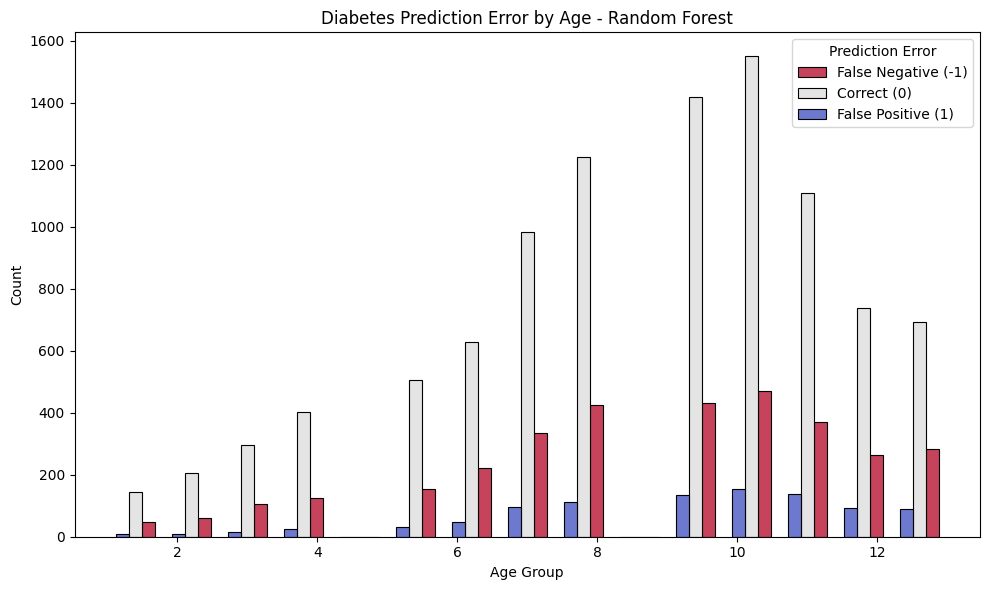

In [83]:
test_diabetes_rf['diabetes_error'] = test_diabetes_rf['pred_diabetes'] - test_diabetes_rf['Diabetes_binary']

plt.figure(figsize=(10, 6))
sns.histplot(data=test_diabetes_rf, x='Age', hue='diabetes_error', bins=15, multiple='dodge', palette='coolwarm', shrink=0.7)

plt.title('Diabetes Prediction Error by Age - Random Forest')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Prediction Error', labels=['False Negative (-1)', 'Correct (0)', 'False Positive (1)'])
plt.tight_layout()
plt.show()

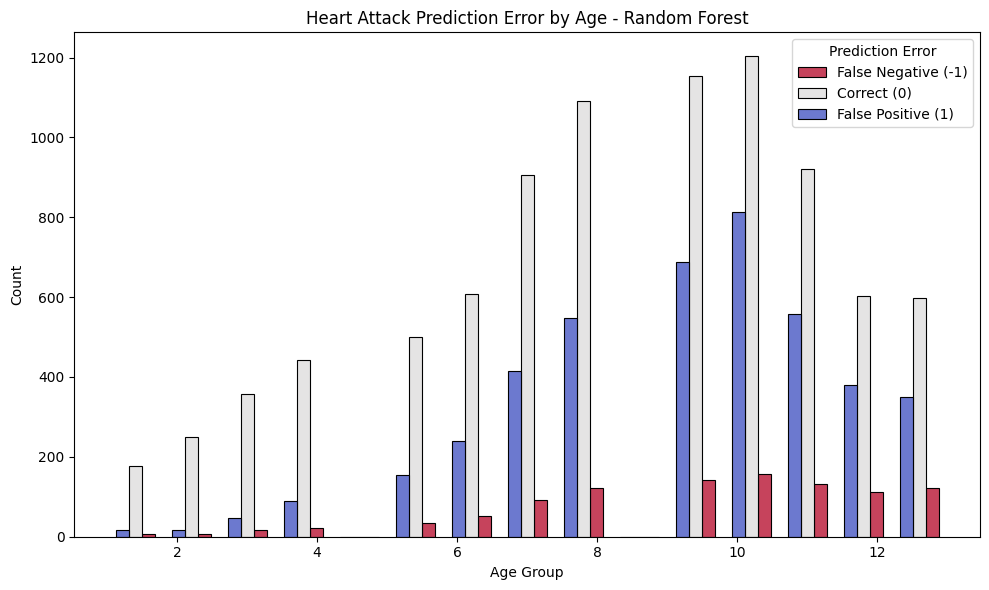

In [84]:
test_heart_rf['heart_error'] = test_heart_rf['pred_heart'] - test_heart_rf['Diabetes_binary']

plt.figure(figsize=(10, 6))
sns.histplot(data=test_heart_rf, x='Age', hue='heart_error', bins=15, multiple='dodge', palette='coolwarm', shrink=0.7)

plt.title('Heart Attack Prediction Error by Age - Random Forest')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Prediction Error', labels=['False Negative (-1)', 'Correct (0)', 'False Positive (1)'])
plt.tight_layout()
plt.show()

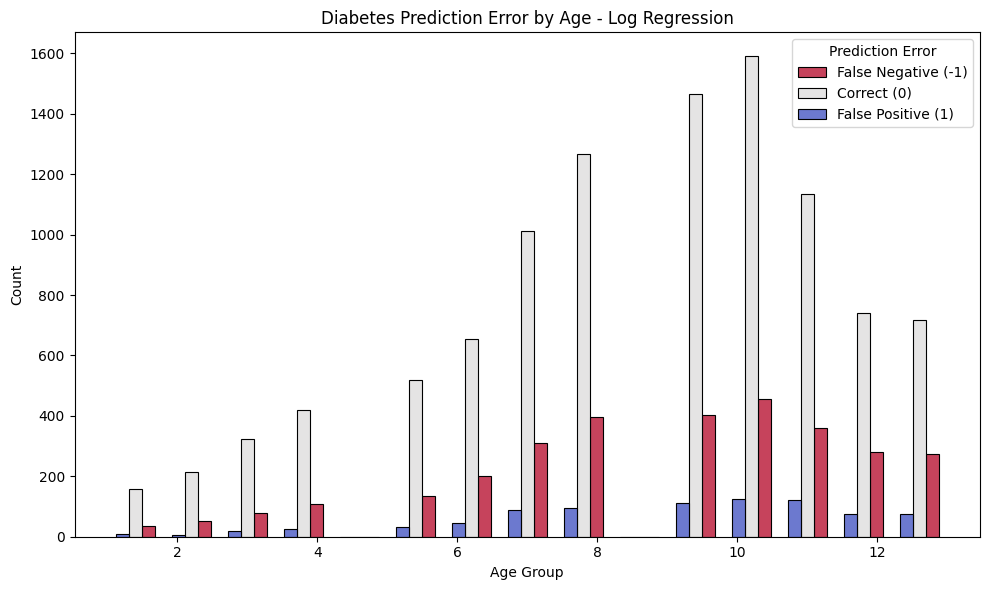

In [85]:
test_diabetes_log['diabetes_error'] = test_diabetes_log['pred_diabetes'] - test_diabetes_log['Diabetes_binary']

plt.figure(figsize=(10, 6))
sns.histplot(data=test_diabetes_log, x='Age', hue='diabetes_error', bins=15, multiple='dodge', palette='coolwarm', shrink=0.7)

plt.title('Diabetes Prediction Error by Age - Log Regression')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Prediction Error', labels=['False Negative (-1)', 'Correct (0)', 'False Positive (1)'])
plt.tight_layout()
plt.show()

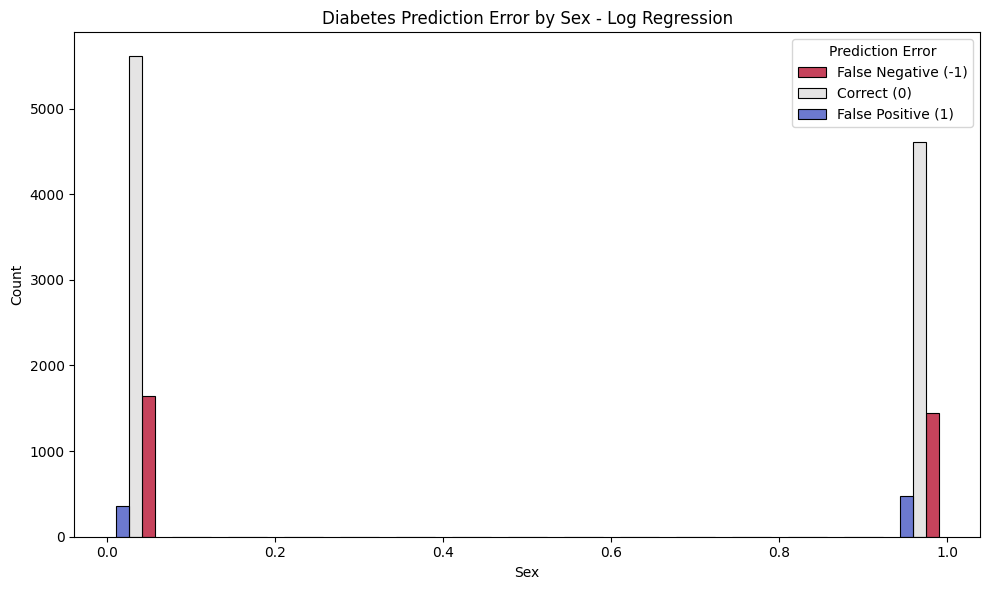

In [86]:
test_diabetes_log['diabetes_error'] = test_diabetes_log['pred_diabetes'] - test_diabetes_log['Diabetes_binary']

plt.figure(figsize=(10, 6))
sns.histplot(data=test_diabetes_log, x='Sex', hue='diabetes_error', bins=15, multiple='dodge', palette='coolwarm', shrink=0.7)

plt.title('Diabetes Prediction Error by Sex - Log Regression')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Prediction Error', labels=['False Negative (-1)', 'Correct (0)', 'False Positive (1)'])
plt.tight_layout()
plt.show()

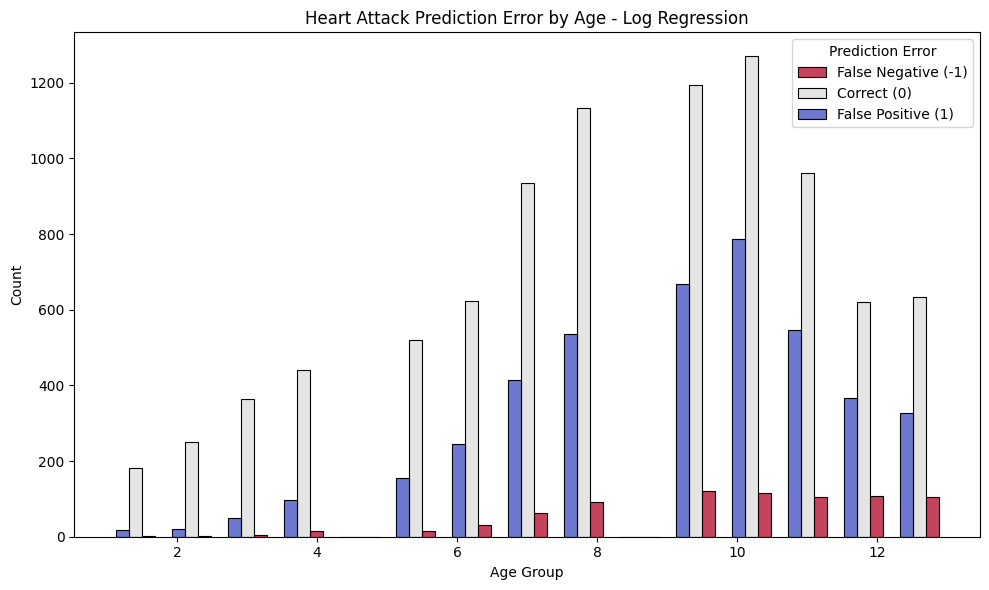

In [87]:
test_heart_log['heart_error'] = test_heart_log['pred_heart'] - test_heart_log['Diabetes_binary']

plt.figure(figsize=(10, 6))
sns.histplot(data=test_heart_log, x='Age', hue='heart_error', bins=15, multiple='dodge', palette='coolwarm', shrink=0.7)

plt.title('Heart Attack Prediction Error by Age - Log Regression')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Prediction Error', labels=['False Negative (-1)', 'Correct (0)', 'False Positive (1)'])
plt.tight_layout()
plt.show()

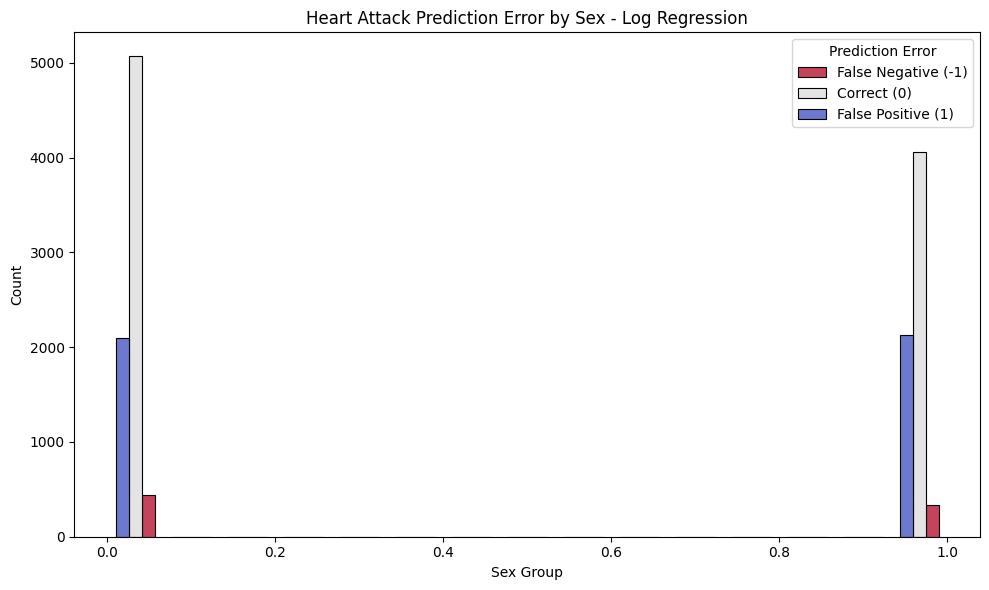

In [88]:
test_heart_log['heart_error'] = test_heart_log['pred_heart'] - test_heart_log['Diabetes_binary']

plt.figure(figsize=(10, 6))
sns.histplot(data=test_heart_log, x='Sex', hue='heart_error', bins=15, multiple='dodge', palette='coolwarm', shrink=0.7)

plt.title('Heart Attack Prediction Error by Sex - Log Regression')
plt.xlabel('Sex Group')
plt.ylabel('Count')
plt.legend(title='Prediction Error', labels=['False Negative (-1)', 'Correct (0)', 'False Positive (1)'])
plt.tight_layout()
plt.show()

In [89]:
# Diabetes - Logistic Regression
acc_diabetes_log = 1 - test_diabetes_log.groupby('Age')['diabetes_error'].apply(lambda x: (x != 0).mean())

# Heart - Logistic Regression
acc_heart_log = 1 - test_heart_log.groupby('Age')['heart_error'].apply(lambda x: (x != 0).mean())

# Diabetes - Random Forest
acc_diabetes_rf = 1 - test_diabetes_rf.groupby('Age')['diabetes_error'].apply(lambda x: (x != 0).mean())

# Heart - Random Forest
acc_heart_rf = 1 - test_heart_rf.groupby('Age')['heart_error'].apply(lambda x: (x != 0).mean())

In [90]:
# Combine into one DataFrame
accuracy_by_age = pd.DataFrame({
    'Diabetes_Logistic': acc_diabetes_log,
    'Heart_Logistic': acc_heart_log,
    'Diabetes_RF': acc_diabetes_rf,
    'Heart_RF': acc_heart_rf
})

# Calculate pairwise differences if needed
accuracy_diffs = accuracy_by_age.diff(axis=1).abs()  # absolute difference between consecutive columns

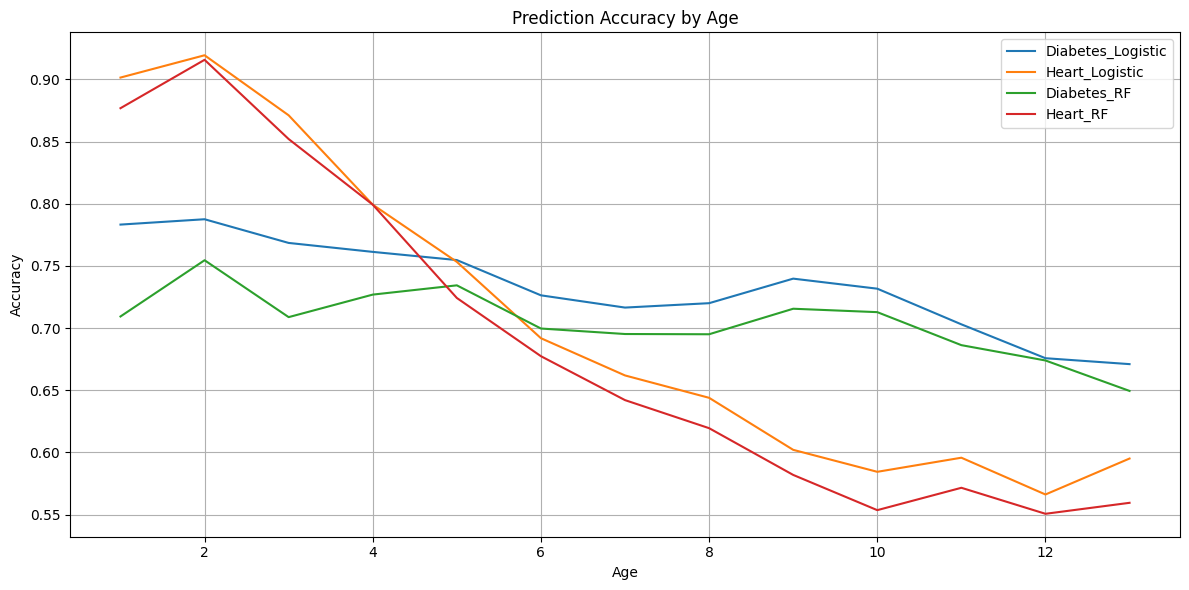

In [91]:
accuracy_by_age.plot(figsize=(12, 6), title='Prediction Accuracy by Age')
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
# Diabetes - Logistic Regression
acc_diabetes_log = 1 - test_diabetes_log.groupby('Sex')['diabetes_error'].apply(lambda x: (x != 0).mean())

# Heart - Logistic Regression
acc_heart_log = 1 - test_heart_log.groupby('Sex')['heart_error'].apply(lambda x: (x != 0).mean())

# Diabetes - Random Forest
acc_diabetes_rf = 1 - test_diabetes_rf.groupby('Sex')['diabetes_error'].apply(lambda x: (x != 0).mean())

# Heart - Random Forest
acc_heart_rf = 1 - test_heart_rf.groupby('Sex')['heart_error'].apply(lambda x: (x != 0).mean())

In [93]:
# Combine into one DataFrame
accuracy_by_sex = pd.DataFrame({
    'Diabetes_Logistic': acc_diabetes_log,
    'Heart_Logistic': acc_heart_log,
    'Diabetes_RF': acc_diabetes_rf,
    'Heart_RF': acc_heart_rf
})

# Calculate pairwise differences if needed
accuracy_diffs = accuracy_by_sex.diff(axis=1).abs()  # absolute difference between consecutive columns

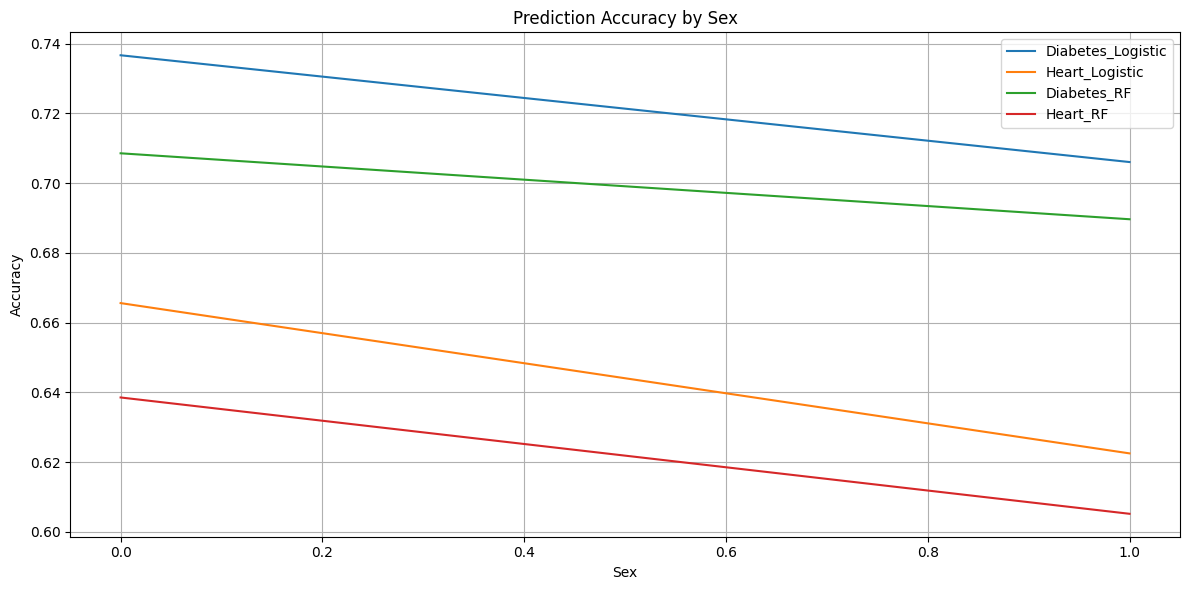

In [94]:
accuracy_by_sex.plot(figsize=(12, 6), title='Prediction Accuracy by Sex')
plt.xlabel('Sex')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

# Preprocessing Algorithm

In [95]:
train_df = df.copy()

# Split once, then reuse for both targets
train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df[['Diabetes_binary', 'HeartDiseaseorAttack']])

# Split into target-specific versions
# For diabetes
train_df_diabetes = train_data.copy()
train_df_diabetes['label'] = train_df_diabetes['Diabetes_binary']
train_df_diabetes = train_df_diabetes.drop(columns=['Diabetes_binary'])

test_df_diabetes = test_data.copy()
test_df_diabetes['label'] = test_df_diabetes['Diabetes_binary']
test_df_diabetes_bld = test_df_diabetes.drop(columns=['Diabetes_binary'])

# For heart disease
train_df_heart = train_data.copy()
train_df_heart['label'] = train_df_heart['HeartDiseaseorAttack']
train_df_heart = train_df_heart.drop(columns=['HeartDiseaseorAttack'])

test_df_heart = test_data.copy()
test_df_heart['label'] = test_df_heart['HeartDiseaseorAttack']
test_df_heart_bld = test_df_heart.drop(columns=['HeartDiseaseorAttack'])

def train_fair_logistic_model(df, target, protected_classes, priv, unpriv):
    df = df.copy()

    bld = BinaryLabelDataset(
        df=df,
        label_names=['label'],
        protected_attribute_names=protected_classes,
        favorable_label=1,
        unfavorable_label=0
    )

    rw = Reweighing(unprivileged_groups=unpriv, privileged_groups=priv)
    bld_rw = rw.fit_transform(bld)

    X = pd.DataFrame(bld_rw.features, columns=bld_rw.feature_names)
    y = bld_rw.labels.ravel()
    weights = bld_rw.instance_weights

    model = LogisticRegression(max_iter=1000)
    model.fit(X, y, sample_weight=weights)

    return model, bld_rw, rw

In [96]:
# Train diabetes model
clf_diabetes, train_rw_diabetes, rw_diabetes = train_fair_logistic_model(
    df=train_df_diabetes,
    target='Diabetes_binary',
    protected_classes=protected_classes,
    priv=privileged_groups,
    unpriv=unprivileged_groups
)

# Train heart model using reweighing mitigation
clf_heart, train_rw_heart, rw_heart = train_fair_logistic_model(
    df=train_df_heart,
    target='HeartDiseaseorAttack',
    protected_classes=protected_classes,
    priv=privileged_groups,
    unpriv=unprivileged_groups
)

# Create test BLD - daibetes
test_bld_diabetes = BinaryLabelDataset(
    df=test_df_diabetes.drop(columns=['Diabetes_binary']),
    label_names=['label'],  
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0
)

# Create test BLD - heart attackss
test_bld_heart = BinaryLabelDataset(
    df=test_df_heart.drop(columns=['HeartDiseaseorAttack']),
    label_names=['label'], 
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0
)

# Apply the reweighing object to the testing data
test_rw_diabetes = rw_diabetes.transform(test_bld_diabetes)
test_rw_heart = rw_heart.transform(test_bld_heart)

# Now use the features
X_diabetes_test = pd.DataFrame(test_rw_diabetes.features, columns=test_rw_diabetes.feature_names)
X_heart_test = pd.DataFrame(test_rw_heart.features, columns=test_rw_heart.feature_names)
y_diabetes_true = test_rw_diabetes.labels.ravel()
y_heart_true = test_rw_heart.labels.ravel()

In [97]:
# Predict labels and probabilities
y_diabetes_pred = clf_diabetes.predict(X_diabetes_test)
y_diabetes_proba = clf_diabetes.predict_proba(X_diabetes_test)[:, 1]

y_heart_pred = clf_heart.predict(X_heart_test)
y_heart_proba = clf_heart.predict_proba(X_heart_test)[:, 1]

In [98]:
y_diabetes_true = test_df_diabetes['Diabetes_binary']  # Ground truth
y_heart_true = test_df_heart['HeartDiseaseorAttack'] # Ground truth

# Diabetes Metrics
diabetes_accuracy = accuracy_score(y_diabetes_true, y_diabetes_pred)
diabetes_f1_macro = f1_score(y_diabetes_true, y_diabetes_pred, average='macro')
diabetes_conf_matrix = confusion_matrix(y_diabetes_true, y_diabetes_pred)
diabetes_tn, diabetes_fp, diabetes_fn, diabetes_tp = diabetes_conf_matrix.ravel()
diabetes_classification_report = classification_report(y_diabetes_true, y_diabetes_pred)

# Heart disease metrics
heart_accuracy = accuracy_score(y_heart_true, y_heart_pred)
heart_f1_macro = f1_score(y_heart_true, y_heart_pred, average='macro')
heart_conf_matrix = confusion_matrix(y_heart_true, y_heart_pred)
heart_tn, heart_fp, heart_fn, heart_tp = heart_conf_matrix.ravel()
heart_classification_report = classification_report(y_heart_true, y_heart_pred)

print("Diabetes_binary Model Evaluation - Reweighing of Logistic Regression")
print("----------------------------------")
print(f"Accuracy: {diabetes_accuracy:.4f}")
print(f"F1 Score (macro): {diabetes_f1_macro:.4f}")
print("\nConfusion Matrix:")
print(f"[[TN: {diabetes_tn}  FP: {diabetes_fp}]\n [FN: {diabetes_fn}  TP: {diabetes_tp}]]")

print("\nClassification Report:")
print(diabetes_classification_report)

print("\nHeartDiseaseorAttack Model Evaluation - Reweighing of Logistic Regression")
print("----------------------------------------")
print(f"Accuracy: {heart_accuracy:.4f}")
print(f"F1 Score (macro): {heart_f1_macro:.4f}")
print("\nConfusion Matrix:")
print(f"[[TN: {heart_tn}  FP: {heart_fp}]\n [FN: {heart_fn}  TP: {heart_tp}]]")

print("\nClassification Report:")
print(heart_classification_report)

Diabetes_binary Model Evaluation - Reweighing of Logistic Regression
----------------------------------
Accuracy: 0.7387
F1 Score (macro): 0.7386

Confusion Matrix:
[[TN: 5101  FP: 1968]
 [FN: 1727  TP: 5343]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73      7069
         1.0       0.73      0.76      0.74      7070

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139


HeartDiseaseorAttack Model Evaluation - Reweighing of Logistic Regression
----------------------------------------
Accuracy: 0.8584
F1 Score (macro): 0.6032

Confusion Matrix:
[[TN: 11738  FP: 311]
 [FN: 1691  TP: 399]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     12049
         1.0       0.56      0.19      0.28      2090

    accuracy                  

In [99]:
def compute_metrics_for_attribute(dataset_true, dataset_pred, attr):
    results = {}
    unprivileged_groups = [{attr: 0}]
    privileged_groups = [{attr: 1}]

    metric = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )

    results['Disparate Impact'] = metric.disparate_impact()
    results['Equal Opportunity Diff'] = metric.equal_opportunity_difference()
    return results

# Reconstruct prediction datasets as BinaryLabelDataset for AIF360
test_diabetes_log = test_df_diabetes.copy()
test_diabetes_log['prediction'] = y_diabetes_pred
test_diabetes_log['score'] = y_diabetes_proba

test_heart_log = test_df_heart.copy()
test_heart_log['prediction'] = y_heart_pred
test_heart_log['score'] = y_heart_proba

# Convert to BinaryLabelDataset
aif_diabetes = BinaryLabelDataset(
    df=test_diabetes_log,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)
aif_diabetes_pred = aif_diabetes.copy()
aif_diabetes_pred.labels = test_diabetes_log['prediction'].values.reshape(-1, 1)

aif_heart = BinaryLabelDataset(
    df=test_heart_log,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)
aif_heart_pred = aif_heart.copy()
aif_heart_pred.labels = test_heart_log['prediction'].values.reshape(-1, 1)

# Compute metrics for both protected attributes
records = []
for attr in ['Sex', 'Age_binary']:
    diabetes_metrics = compute_metrics_for_attribute(aif_diabetes, aif_diabetes_pred, attr)
    heart_metrics = compute_metrics_for_attribute(aif_heart, aif_heart_pred, attr)

    records.append({
        'Protected Attribute': attr,
        'Outcome': 'Diabetes_binary',
        'Disparate Impact': round(diabetes_metrics['Disparate Impact'], 3),
        'Equal Opportunity Diff': round(diabetes_metrics['Equal Opportunity Diff'], 3)
    })

    records.append({
        'Protected Attribute': attr,
        'Outcome': 'HeartDiseaseorAttack',
        'Disparate Impact': round(heart_metrics['Disparate Impact'], 3),
        'Equal Opportunity Diff': round(heart_metrics['Equal Opportunity Diff'], 3)
    })

# Display as formatted table
df_fairness_metrics = pd.DataFrame(records)
print(df_fairness_metrics.to_string(index=False))

Protected Attribute              Outcome  Disparate Impact  Equal Opportunity Diff
                Sex      Diabetes_binary             0.747                  -0.102
                Sex HeartDiseaseorAttack             0.247                  -0.151
         Age_binary      Diabetes_binary             1.907                   0.104
         Age_binary HeartDiseaseorAttack             4.403                   0.041


In [110]:
# Prepare DataFrames with predictions for AIF360
test_df_diabetes_eval = test_df_diabetes.copy()
test_df_diabetes_eval['label'] = y_diabetes_true
test_df_diabetes_eval['prediction'] = y_diabetes_pred
test_df_diabetes_eval['score'] = clf_diabetes.predict_proba(X_diabetes_test)[:, 1]  # predicted probabilities

test_df_heart_eval = test_df_heart.copy()
test_df_heart_eval['label'] = y_heart_true
test_df_heart_eval['prediction'] = y_heart_pred
test_df_heart_eval['score'] = clf_heart.predict_proba(X_heart_test)[:, 1]

# Create AIF360 BinaryLabelDatasets for evaluation
aif_diabetes_eval = BinaryLabelDataset(
    df=test_df_diabetes_eval,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)

aif_diabetes_pred_eval = aif_diabetes_eval.copy()
aif_diabetes_pred_eval.labels = test_df_diabetes_eval['prediction'].values.reshape(-1, 1)

aif_heart_eval = BinaryLabelDataset(
    df=test_df_heart_eval,
    label_names=['label'],
    protected_attribute_names=protected_classes,
    favorable_label=1,
    unfavorable_label=0,
    scores_names=['score']
)

aif_heart_pred_eval = aif_heart_eval.copy()
aif_heart_pred_eval.labels = test_df_heart_eval['prediction'].values.reshape(-1, 1)

# Define protected groups exactly as in your training
unprivileged_groups = [{'Sex': 0, 'Age_binary': 0}]
privileged_groups = [{'Sex': 1, 'Age_binary': 1}]

# Compute metrics for Diabetes
metric_diabetes_eval = ClassificationMetric(
    aif_diabetes_eval,
    aif_diabetes_pred_eval,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("Disparate Impact (Diabetes):", metric_diabetes_eval.disparate_impact())
print("Equal Opportunity Difference (Diabetes):", metric_diabetes_eval.equal_opportunity_difference())

# Compute metrics for Heart Disease
metric_heart_eval = ClassificationMetric(
    aif_heart_eval,
    aif_heart_pred_eval,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\nDisparate Impact (Heart Disease):", metric_heart_eval.disparate_impact())
print("Equal Opportunity Difference (Heart Disease):", metric_heart_eval.equal_opportunity_difference())

results = []

# 1. Metrics by Sex only
unprivileged_sex = [{'Sex': 0}]
privileged_sex = [{'Sex': 1}]

metric_diabetes_sex = ClassificationMetric(
    aif_diabetes_eval,
    aif_diabetes_pred_eval,
    unprivileged_groups=unprivileged_sex,
    privileged_groups=privileged_sex
)

results.append({
    'Protected Attribute': 'Sex Female',
    'Outcome': 'Diabetes_binary',
    'Disparate Impact': round(metric_diabetes_sex.disparate_impact(), 3),
    'Equal Opportunity Diff': round(metric_diabetes_sex.equal_opportunity_difference(), 3)
})

metric_heart_sex = ClassificationMetric(
    aif_heart_eval,
    aif_heart_pred_eval,
    unprivileged_groups=unprivileged_sex,
    privileged_groups=privileged_sex
)

results.append({
    'Protected Attribute': 'Sex Female',
    'Outcome': 'HeartDiseaseorAttack',
    'Disparate Impact': round(metric_heart_sex.disparate_impact(), 3),
    'Equal Opportunity Diff': round(metric_heart_sex.equal_opportunity_difference(), 3)
})


# 2. Metrics by Age_binary only
unprivileged_age = [{'Age_binary': 0}]
privileged_age = [{'Age_binary': 1}]

metric_diabetes_age = ClassificationMetric(
    aif_diabetes_eval,
    aif_diabetes_pred_eval,
    unprivileged_groups=unprivileged_age,
    privileged_groups=privileged_age
)

results.append({
    'Protected Attribute': 'Age_binary (over 53)',
    'Outcome': 'Diabetes_binary',
    'Disparate Impact': round(metric_diabetes_age.disparate_impact(), 3),
    'Equal Opportunity Diff': round(metric_diabetes_age.equal_opportunity_difference(), 3)
})

metric_heart_age = ClassificationMetric(
    aif_heart_eval,
    aif_heart_pred_eval,
    unprivileged_groups=unprivileged_age,
    privileged_groups=privileged_age
)

results.append({
    'Protected Attribute': 'Age_binary (over 53)',
    'Outcome': 'HeartDiseaseorAttack',
    'Disparate Impact': round(metric_heart_age.disparate_impact(), 3),
    'Equal Opportunity Diff': round(metric_heart_age.equal_opportunity_difference(), 3)
})

# Convert to DataFrame for nicer display or CSV export
import pandas as pd
df_metrics = pd.DataFrame(results)
print(df_metrics)

Disparate Impact (Diabetes): 1.4192834446089717
Equal Opportunity Difference (Diabetes): 0.012623553879278049

Disparate Impact (Heart Disease): 1.1037454997315794
Equal Opportunity Difference (Heart Disease): -0.11687382183647343
    Protected Attribute               Outcome  Disparate Impact  \
0            Sex Female       Diabetes_binary             0.747   
1            Sex Female  HeartDiseaseorAttack             0.247   
2  Age_binary (over 53)       Diabetes_binary             1.907   
3  Age_binary (over 53)  HeartDiseaseorAttack             4.403   

   Equal Opportunity Diff  
0                  -0.102  
1                  -0.151  
2                   0.104  
3                   0.041  


In [111]:
# Fairness metrics for Diabetes by Sex
metric_diabetes_sex = ClassificationMetric(
    aif_diabetes_eval,
    aif_diabetes_pred_eval,
    unprivileged_groups=[{'Sex': 0}],
    privileged_groups=[{'Sex': 1}]
)

print("Diabetes by Sex")
print("Disparate Impact:", metric_diabetes_sex.disparate_impact())
print("Equal Opportunity Difference:", metric_diabetes_sex.equal_opportunity_difference())

Diabetes by Sex
Disparate Impact: 0.7474656665546687
Equal Opportunity Difference: -0.10153807248025037


In [112]:
def compute_group_metrics_by_attribute(
    aif_true: BinaryLabelDataset,
    aif_pred: BinaryLabelDataset,
    protected_attribute: str,
    label_name: str = 'label'
):
    groups = aif_true.convert_to_dataframe()[0][protected_attribute].unique()
    results = []

    for group in sorted(groups):
        unpriv_group = [{protected_attribute: group}]
        metric = ClassificationMetric(
            aif_true,
            aif_pred,
            unprivileged_groups=unpriv_group,
            privileged_groups=[]
        )

        results.append({
            'Protected Attribute': protected_attribute,
            'Group Value': group,
            'Outcome': label_name,
            'Selection Rate': round(metric.selection_rate(), 4),
            'True Positive Rate': round(metric.true_positive_rate(), 4)
        })

    return pd.DataFrame(results)



In [113]:
sex_diabetes_df = compute_group_metrics_by_attribute(
    aif_true=aif_diabetes_eval,
    aif_pred=aif_diabetes_pred_eval,
    protected_attribute='Sex',
    label_name='Diabetes_binary'
)
print(sex_diabetes_df)

age_diabetes_df = compute_group_metrics_by_attribute(
    aif_true=aif_diabetes_eval,
    aif_pred=aif_diabetes_pred_eval,
    protected_attribute='Age_binary',
    label_name='Diabetes_binary'
)
print(age_diabetes_df)

  Protected Attribute  Group Value          Outcome  Selection Rate  \
0                 Sex          0.0  Diabetes_binary          0.5171   
1                 Sex          1.0  Diabetes_binary          0.5171   

   True Positive Rate  
0              0.7557  
1              0.7557  
  Protected Attribute  Group Value          Outcome  Selection Rate  \
0          Age_binary          0.0  Diabetes_binary          0.5171   
1          Age_binary          1.0  Diabetes_binary          0.5171   

   True Positive Rate  
0              0.7557  
1              0.7557  


In [114]:
# Diabetes fairness breakdown by Sex
sex_diabetes_log_df = compute_group_metrics_by_attribute(
    aif_true=aif_diabetes,
    aif_pred=aif_diabetes_pred,
    protected_attribute='Sex',
    label_name='Diabetes_binary'
)

# Diabetes fairness breakdown by Age_binary
age_diabetes_log_df = compute_group_metrics_by_attribute(
    aif_true=aif_diabetes,
    aif_pred=aif_diabetes_pred,
    protected_attribute='Age_binary',
    label_name='Diabetes_binary'
)

# Heart disease fairness breakdown by Sex
sex_heart_log_df = compute_group_metrics_by_attribute(
    aif_true=aif_heart,
    aif_pred=aif_heart_pred,
    protected_attribute='Sex',
    label_name='HeartDiseaseorAttack'
)

# Heart disease fairness breakdown by Age_binary
age_heart_log_df = compute_group_metrics_by_attribute(
    aif_true=aif_heart,
    aif_pred=aif_heart_pred,
    protected_attribute='Age_binary',
    label_name='HeartDiseaseorAttack'
)

# Combine all into one DataFrame (optional)
all_metrics_df = pd.concat([
    sex_diabetes_log_df,
    age_diabetes_log_df,
    sex_heart_log_df,
    age_heart_log_df
], ignore_index=True)

# Preview or export
print(all_metrics_df)

  Protected Attribute  Group Value               Outcome  Selection Rate  \
0                 Sex          0.0       Diabetes_binary          0.5171   
1                 Sex          1.0       Diabetes_binary          0.5171   
2          Age_binary          0.0       Diabetes_binary          0.5171   
3          Age_binary          1.0       Diabetes_binary          0.5171   
4                 Sex          0.0  HeartDiseaseorAttack          0.0502   
5                 Sex          1.0  HeartDiseaseorAttack          0.0502   
6          Age_binary          0.0  HeartDiseaseorAttack          0.0502   
7          Age_binary          1.0  HeartDiseaseorAttack          0.0502   

   True Positive Rate  
0              0.7557  
1              0.7557  
2              0.7557  
3              0.7557  
4              0.1909  
5              0.1909  
6              0.1909  
7              0.1909  
